In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from math import log2, floor, ceil
from statistics import mean, median

In [30]:
def load_file(filename, line=0):
    a = np.loadtxt(filename, dtype='str', comments='#')
    rsp = [round(float(x),6) for x in  a[:,line]]
    latencies = a[:,1]
    times = a[:,2]
    processors = a[:,3]
    work = a[:,4]
    i_steals = a[:,16]
    e_steals = a[:,17]
    return rsp, latencies, times, processors, work#, i_steals, i_steals

directory_s = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_50p/"
directory_s_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_70p/"
directory_s_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_80p/"
directory_s_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_static/static_steal_90p/"

directory_pd = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_50p/"
directory_pd_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_70p/"
directory_pd_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_80p/"
directory_pd_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba_dynamic/proba_dynamic_steal_90p/"

directory_p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_50p/"
directory_p_70p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_70p/"
directory_p_80p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_80p/"
directory_p_90p = "/home/khatiri/these/projet/ws-simulator/Simulation/strategy_proba/proba_steal_90p/"


#/home/khatiri/these/projet/ws-simulator/Simulation/proba/"

In [31]:
def compute_average(values, latence):
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            run_number[float(rsp[i])] += 1
            average[float(rsp[i])] += int(values[i])
            
    for cle in average:
        average[cle] /= run_number[cle]
    return average

def compute_overhead_for_latence(data, latence):
    rsp, latencies, times, processors, work = data
    all_average = defaultdict(list)
    average = defaultdict(int)
    run_number = defaultdict(int)
    
    for i in range(len(rsp)):
        if int(latencies[i]) == latence:
            #run_number[float(rsp[i])] += 1
            all_average[float(rsp[i])].append(float(int(times[i]) - int(work[i])/int(processors[i])))
    for cle in sorted(all_average):
        size = len(all_average[cle])
        #average[cle] = mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)])
        average[cle] = mean(all_average[cle])
        #print(mean(all_average[cle]), mean(all_average[cle][ceil(0.25*size):ceil(0.75*size)]))
  #      average[cle] = median(all_average[cle])

    return all_average, average, min(average.keys(), key=lambda x : average[x])


def compute_overhead(data, latence, variable):
    rsp, latencies, times, processors, work = data
    average = defaultdict(int)
    run_number = defaultdict(int)
    average = 0
    run_number = 0
    
    for i in range(len(rsp)):
        if float(rsp[i]) == variable and float(latencies[i]) == latence:
            run_number += 1
            average += float(int(times[i]) - int(work[i])/int(processors[i]))
            
    return average/run_number

In [32]:
def plot_for_best(filename, cond_base_line=False):
    best = dict()
    base_line = dict()
    data = load_file(filename)
    latencies = data[1]
    for latence in sorted(set(latencies), key=lambda x: int(x)):
        if int(latence) >= 64:
            all_average, avg_overhead, minimum  = compute_overhead_for_latence(data, int(latence))
            best_avg_overhead = compute_overhead(data, int(latence), minimum)
            best[latence] = best_avg_overhead
            if cond_base_line:
                base_line[latence] = compute_overhead(data, int(latence), 0.5)
                #print(latence, minimum)
    
    return best, base_line

In [33]:
def latence_for_best_param(filename):
    data = load_file(filename)
    latencies = data[1]
    best = dict()

    for latence in sorted(set(latencies), key=lambda x: int(x)):
        all_average, overhead, minimum = compute_overhead_for_latence(data, int(latence))
        #plt.subplot(223)
        plt.plot(overhead.keys(), overhead.values())
        best[latence] = minimum
    return best

In [34]:
def best_overhead_dict__(directory):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16, 32, 64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            best, _ = plot_for_best(filename)
            for latence in best.keys():
                best_value_w[(p, int(latence))][w]=best[latence]
                best_value_p[(w, int(latence))][p]=best[latence]
                best_value_l[(w, p)][int(latence)]=best[latence]

    return best_value_w, best_value_p, best_value_l

In [35]:
def best_value_dict__(directory, seuil):
    best_value_p = defaultdict(dict)
    best_value_w = defaultdict(dict)
    best_value_l = defaultdict(dict)

    for w in (10000000,50000000,100000000,500000000):
        for p in (16,32,64):
            filename = directory + "vss_static_" + str(p) + "_" + str(w)
            data = load_file(filename)
            for latence in (128,256,512,1024):
                _, overhead, minimum = compute_overhead_for_latence(data, latence)
                
                overhead_min = overhead[minimum]
                interval_max = overhead[minimum]  + 2*latence/p #+ overhead[minimum]*seuil/100

                #print(minimum, overhead[minimum], interval_max)
                
                
                overhead_plage = list(filter(lambda x : overhead_min <= overhead[x] <= interval_max, overhead))
                
                #print([(x, overhead[x]) for x in overhead_plage])
                
                best_value_w[(p, int(latence))][w]= overhead_plage
                best_value_p[(w, int(latence))][p]= overhead_plage
                best_value_l[(w, p)][int(latence)]= overhead_plage

    return best_value_w, best_value_p, best_value_l



In [36]:
def boxdata__(p, w, l, rspmin, rspmax):
    data = load_file(directory + "vss_static_{}_{}".format(p,w))
    all_average, overhead, minimum = compute_overhead_for_latence(data, l)
    #print(all_average)
    return [all_average[x] for x in all_average.keys() if rspmin <= x and x <= rspmax], \
[round(x,6) for x in all_average.keys() if rspmin <= x and x <= rspmax]


# comparaison entre les strategies

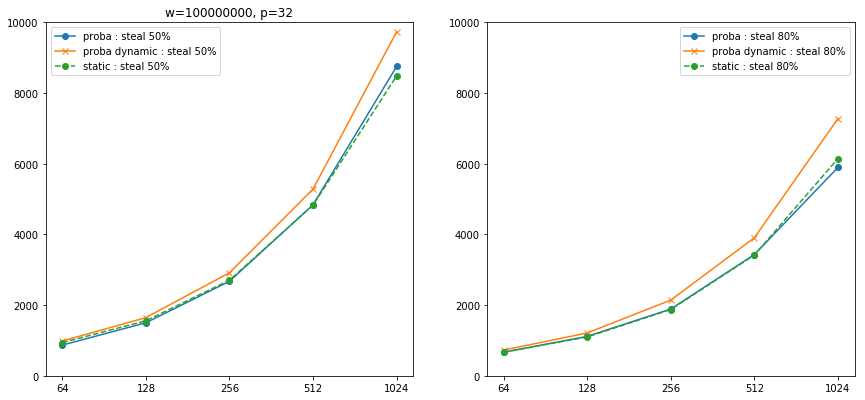

In [10]:
fig = plt.figure()
fig.set_size_inches(14.5, 6.5, forward=True)

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"




w = "100000000"
p = "32"

plt.subplot(121)

plt.ylim(0,10000)
plt.title("w={}, p={}".format(w,p))
filename = directory_p + "vss_proba_"+p+"_"+w
best_proba_50, _ = plot_for_best(filename)

filename = directory_pd + "vss_proba_dynamic_"+p+"_"+w
best_proba_dynamic_50, _ = plot_for_best(filename)

filename = directory_s + "vss_static_"+p+"_"+w
best_static_50, _ = plot_for_best(filename)

plt.plot(best_proba_50.keys(), best_proba_50.values(), 'o-', label="proba : steal 50%")
plt.plot(best_proba_dynamic_50.keys(), best_proba_dynamic_50.values(), 'x-', label="proba dynamic : steal 50%")
plt.plot(best_static_50.keys(), best_static_50.values(), 'o--', label="static : steal 50%")
plt.legend()

plt.subplot(122)
plt.ylim(0,10000)

filename = directory_p_70p + "vss_proba_"+p+"_"+w
best_proba_70, _ = plot_for_best(filename)

filename = directory_pd_70p + "vss_proba_dynamic_"+p+"_"+w
best_proba_dynamic_70, _ = plot_for_best(filename)

filename = directory_s_70p + "vss_static_"+p+"_"+w
best_static_70, _ = plot_for_best(filename)

plt.plot(best_proba_70.keys(), best_proba_70.values(), 'o-', label="proba : steal 80%")
plt.plot(best_proba_dynamic_70.keys(), best_proba_dynamic_70.values(), 'x-', label="proba dynamic : steal 80%")
plt.plot(best_static_70.keys(), best_static_70.values(), 'o--', label="static : steal 80%")
plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/proba_05_vs_08_32_100000000.pdf',bbox_inches='tight')


/home/khatiri/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


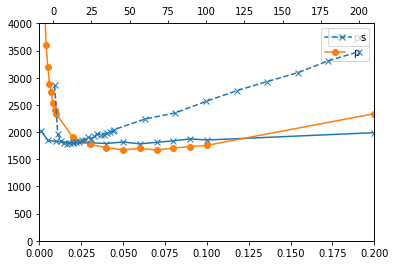

In [11]:
w = "500000000"
p = "64"

fig = plt.figure()
plt.ylim(0,4000)
plt.xlim(0,0.2)
axes1 = fig.add_subplot(111)
axes2 = axes1.twiny()    # share the y-axis


data = load_file(directory_pd + "vss_proba_dynamic_"+p+"_"+w, line=18)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes1.plot(overhead.keys(), overhead.values(), "x-", label="pd")


data = load_file(directory_p + "vss_proba_"+p+"_"+w, line=0)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes1.plot(overhead.keys(), overhead.values(), "o-", label="p")

data = load_file(directory_s + "vss_static_"+p+"_"+w, line=0)
all_average, overhead, minimum = compute_overhead_for_latence(data, 128)
axes2.plot(overhead.keys(), overhead.values(), "x--", label="s")

axes1.legend()
axes2.legend()

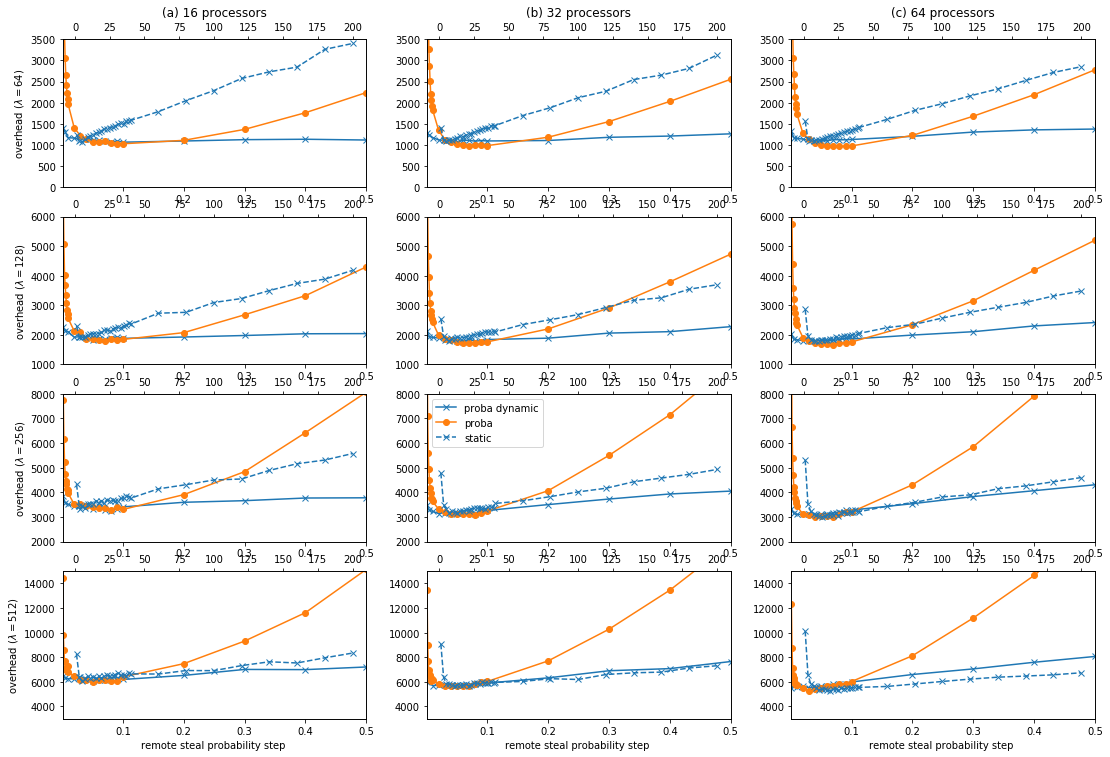

In [22]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

#plt.xlim(0.001, 0.5)
position = 0
#for (l,lim) in sorted({(128,6000),(256,8000),(512,15000)}):
for (l, limy, limx) in sorted({(64,0,3500),(128, 1000, 6000),(256, 2000, 8000),(512,3000, 15000)}):
    
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(4, 3, position)

        #labels
        if l == 512:
            plt.xlabel("remote steal probability step ")
        if l == 64:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0.001, 0.5)
        plt.ylim(limy, limx)
        
        #plots
        axes1 = fig.add_subplot(4, 3, position)
        axes2 = axes1.twiny()    # share the y-axis


        data = load_file(directory_pd + "vss_proba_dynamic_" + str(p) + "_" + str(w), line=18)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns1 = axes1.plot(overhead.keys(), overhead.values(), "x-", label="proba dynamic")


        data = load_file(directory_p + "vss_proba_" + str(p) + "_" + str(w), line=0)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns2 = axes1.plot(overhead.keys(), overhead.values(), "o-", label="proba")

        data = load_file(directory_s + "vss_static_" + str(p) + "_" + str(w), line=0)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns3 = axes2.plot(overhead.keys(), overhead.values(), "x--", label="static")


        #axes1.legend()
        #axes2.legend()             
        #axes1.legend(('label1', 'label2', 'label3'))        #legend
        if p == 32 and l == 256: 
            lns = lns1+lns2+lns3
            labs = [l.get_label() for l in lns]
            axes1.legend(lns, labs, loc=0)


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_vss_50p.pdf',bbox_inches='tight')


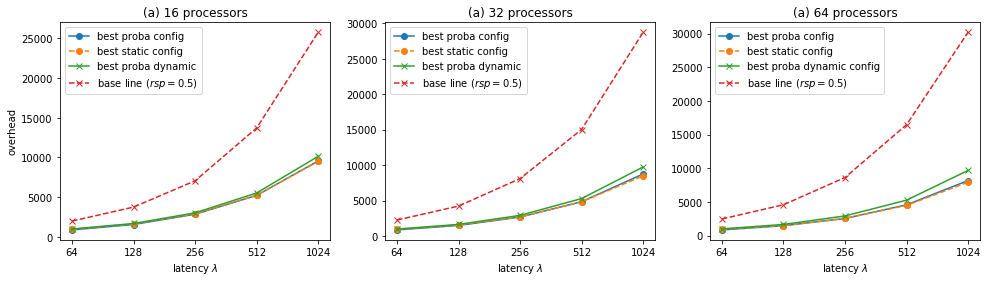

In [18]:
fig = plt.figure()
fig.set_size_inches(16.5, 4, forward=True)
 
#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"


filename = directory_s + "vss_static_16_100000000"
best_static, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_16_100000000"
best_proba, base_line = plot_for_best(filename,cond_base_line=True)

filename = directory_pd + "vss_proba_dynamic_16_100000000"
best_proba_dynamic, _ = plot_for_best(filename)



plt.subplot(131)
plt.title("(a) 16 processors")
plt.ylabel("overhead")
plt.xlabel("latency $\lambda$")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best proba config")
plt.plot(best_static.keys(), best_static.values(), 'o--', label="best static config")
plt.plot(best_proba_dynamic.keys(), best_proba_dynamic.values(), 'x-', label="best proba dynamic")
plt.plot(base_line.keys(), base_line.values(), 'x--', label="base line ($rsp=0.5$)")

plt.legend()

#plt.subplot(234)
#plt.ylabel("overhead gains")

#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o-', label="proba_dynamic/base_line")
#plt.legend()

#---- 32 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory_s + "vss_static_32_100000000"
best_static, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_32_100000000"
best_proba, base_line = plot_for_best(filename,cond_base_line=True)

filename = directory_pd + "vss_proba_dynamic_32_100000000"
best_proba_dynamic, _ = plot_for_best(filename)


plt.subplot(132)
plt.title("(a) 32 processors")
plt.xlabel("latency $\lambda$")

plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best proba config")
plt.plot(best_static.keys(), best_static.values(), 'o--', label="best static config")
plt.plot(best_proba_dynamic.keys(), best_proba_dynamic.values(), 'x-', label="best proba dynamic")
plt.plot(base_line.keys(), base_line.values(), 'x--', label="base line ($rsp=0.5$)")

plt.legend()

#plt.subplot(235)
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o-', label="proba_dynamic/base_line")
#plt.legend()


#---- 64 proc

#filename = "/home/khatiri/these/projet/ws-simulator/Simulation/vss_proba_32_100000000"

filename = directory_s + "vss_static_64_100000000"
best_static, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_64_100000000"
best_proba, base_line = plot_for_best(filename,cond_base_line=True)

filename = directory_pd + "vss_proba_dynamic_64_100000000"
best_proba_dynamic, _ = plot_for_best(filename)


plt.subplot(133)
plt.title("(a) 64 processors")
plt.xlabel("latency $\lambda$")
plt.plot(best_proba.keys(), best_proba.values(), 'o-', label="best proba config")
plt.plot(best_static.keys(), best_static.values(), 'o--', label="best static config")
plt.plot(best_proba_dynamic.keys(), best_proba_dynamic.values(), 'x-', label="best proba dynamic config")
plt.plot(base_line.keys(), base_line.values(), 'x--', label="base line ($rsp=0.5$)")

plt.legend()

#plt.subplot(236)
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'o-', label="static/base_line")
#plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o-', label="proba_dynamic/base_line")
#plt.legend()

plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_vss_for_best_config.pdf',bbox_inches='tight')

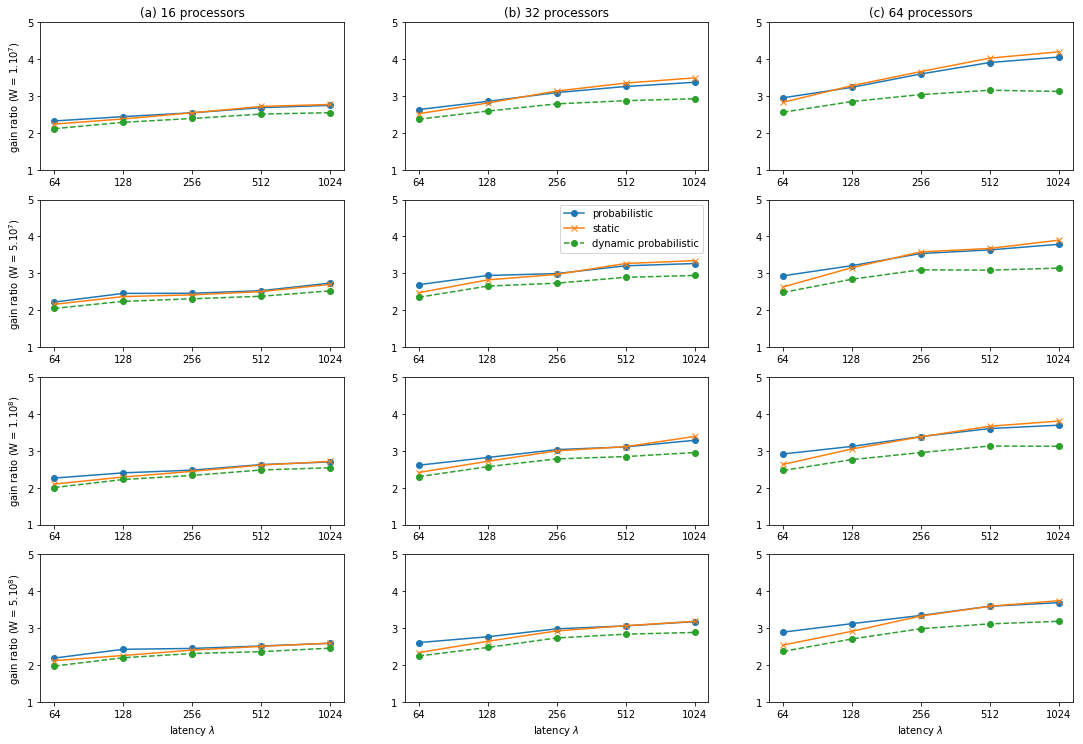

In [37]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        
        
    
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,14000)

        #plots        
        if w1 == 10000000:
            plt.title(c+" "+str(p)+" processors")
        if w1 == 500000000:
            plt.xlabel("latency $\lambda$")
        if p == 16:
            plt.ylabel("gain ratio (W = "+w2+")")
            
        #limits
        plt.ylim(1,5)
        filename = directory_s + "vss_static_" + str(p) + "_" + str(w1) 
        best_static, _ = plot_for_best(filename)

        filename = directory_p + "vss_proba_" + str(p) + "_" + str(w1) 
        best_proba, base_line = plot_for_best(filename,cond_base_line=True)

        filename = directory_pd + "vss_proba_dynamic_" + str(p) + "_" + str(w1) 
        best_proba_dynamic, _ = plot_for_best(filename)
            
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="probabilistic")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'x-', label="static")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o--', label="dynamic probabilistic")
        
        #legend
        if p == 32 and w1 == 50000000: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_ratio_50p.pdf',bbox_inches='tight')


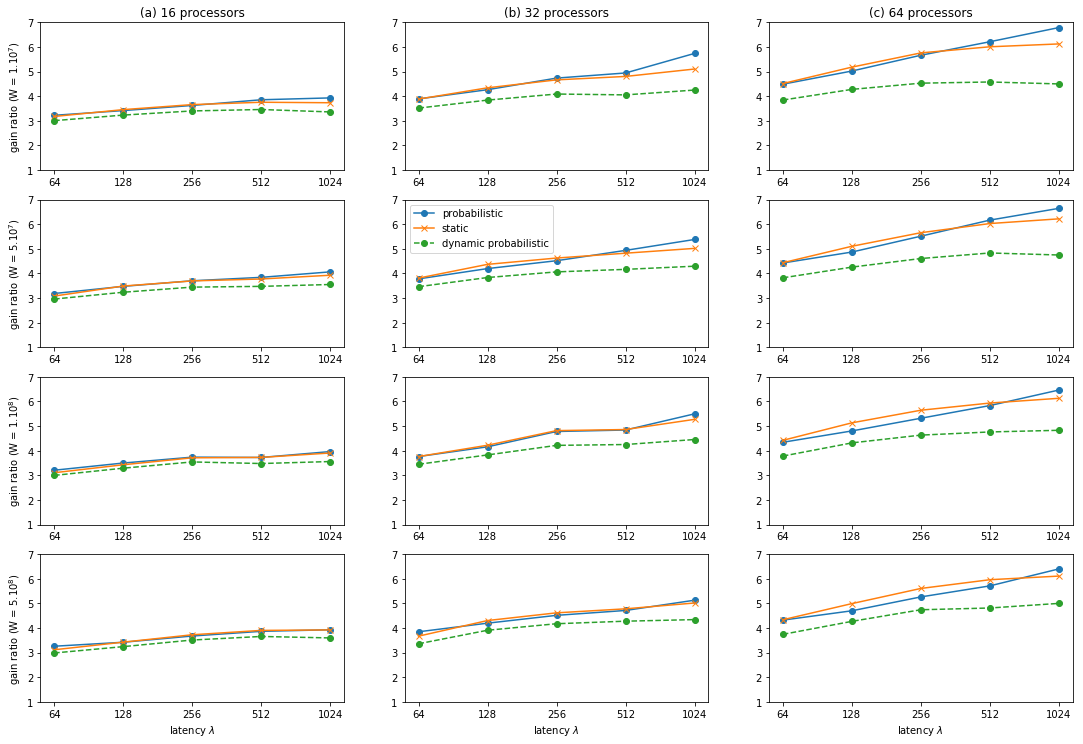

In [27]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        
        
    
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,14000)

        #plots        
        if w1 == 10000000:
            plt.title(c+" "+str(p)+" processors")
        if w1 == 500000000:
            plt.xlabel("latency $\lambda$")
        if p == 16:
            plt.ylabel("gain ratio (W = "+w2+")")
            
        #limits
        plt.ylim(1,7)
        filename = directory_s_70p + "vss_static_" + str(p) + "_" + str(w1) 
        best_static, _ = plot_for_best(filename)

        filename = directory_p_70p + "vss_proba_" + str(p) + "_" + str(w1) 
        best_proba, base_line = plot_for_best(filename,cond_base_line=True)

        filename = directory_pd_70p + "vss_proba_dynamic_" + str(p) + "_" + str(w1) 
        best_proba_dynamic, _ = plot_for_best(filename)
            
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="probabilistic")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'x-', label="static")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o--', label="dynamic probabilistic")
        
        #legend
        if p == 32 and w1 == 50000000: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_ratio_70p.pdf',bbox_inches='tight')


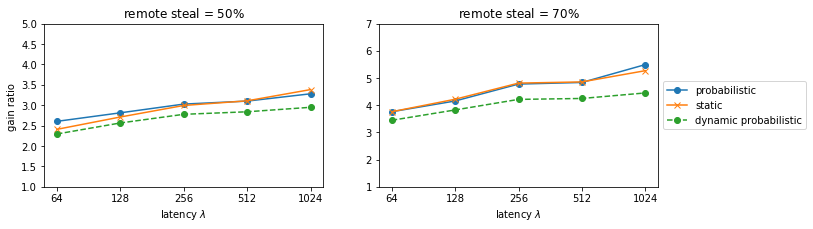

In [38]:
fig = plt.figure()
fig.set_size_inches(11, 3, forward=True)
     
plt.subplot(121)

w1, w2 = (100000000,"$10^8$")
p = 32
plt.ylim(0,14000)
plt.title("remote steal = $50\%$")

        #plots        
plt.xlabel("latency $\lambda$")
plt.ylabel("gain ratio ")
            
plt.ylim(1,5)
filename = directory_s + "vss_static_" + str(p) + "_" + str(w1) 
best_static, _ = plot_for_best(filename)

filename = directory_p + "vss_proba_" + str(p) + "_" + str(w1) 
best_proba, base_line = plot_for_best(filename,cond_base_line=True)

filename = directory_pd + "vss_proba_dynamic_" + str(p) + "_" + str(w1) 
best_proba_dynamic, _ = plot_for_best(filename)
            
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="probabilistic")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'x-', label="static")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o--', label="dynamic probabilistic")
        
        #legend
#plt.legend()


#======================================
plt.subplot(122)

plt.title("remote steal = $70\%$")
plt.xlabel("latency $\lambda$")

#limits
plt.ylim(1,7)
filename = directory_s_70p + "vss_static_" + str(p) + "_" + str(w1) 
best_static, _ = plot_for_best(filename)

filename = directory_p_70p + "vss_proba_" + str(p) + "_" + str(w1) 
best_proba, base_line = plot_for_best(filename,cond_base_line=True)

filename = directory_pd_70p + "vss_proba_dynamic_" + str(p) + "_" + str(w1) 
best_proba_dynamic, _ = plot_for_best(filename)
            
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="probabilistic")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'x-', label="static")
plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o--', label="dynamic probabilistic")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('../../../../../presentation/soutnance_slides/figs/comp_ratio.pdf',bbox_inches='tight')


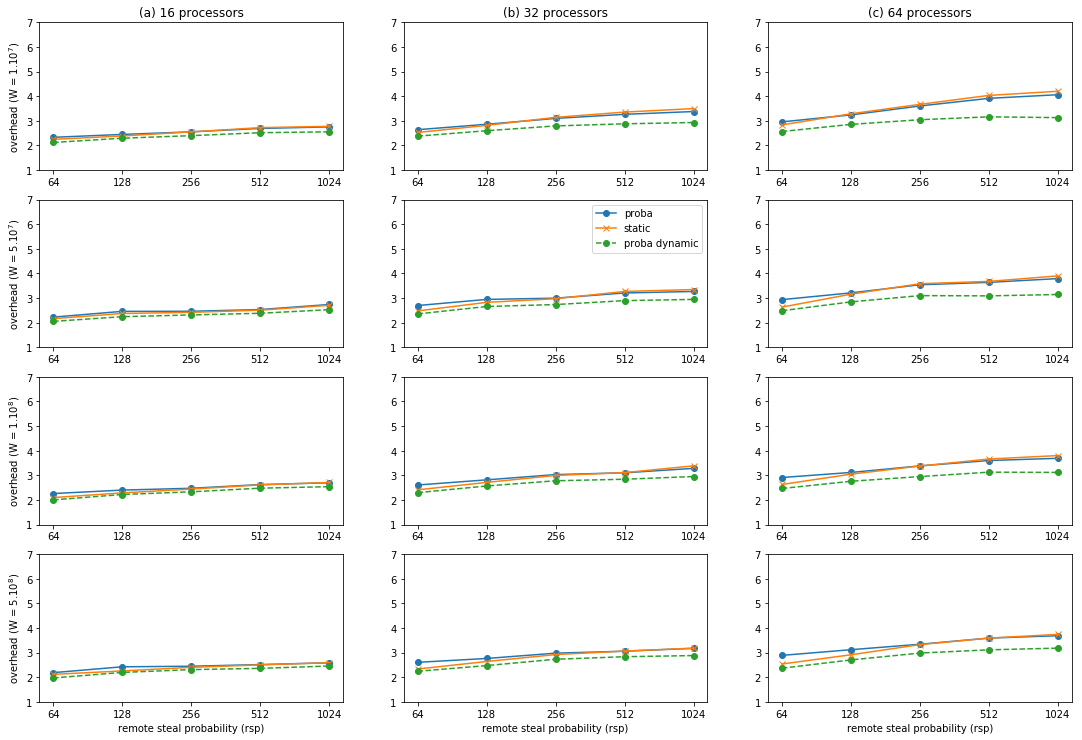

In [39]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

position = 0
for w1, w2 in sorted({(10000000,"1.$10^7$"),(50000000,"5.$10^7$"), (100000000,"1.$10^8$"), (500000000,"5.$10^8$")}):
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        
        
    
        #position
        position += 1
        plt.subplot(4, 3, position)
        plt.ylim(0,14000)

        #plots        
        if w1 == 10000000:
            plt.title(c+" "+str(p)+" processors")
        if w1 == 500000000:
            plt.xlabel("remote steal probability (rsp)")
        if p == 16:
            plt.ylabel("overhead (W = "+w2+")")
            
        #limits
        plt.ylim(1,7)
        filename = directory_s + "vss_static_" + str(p) + "_" + str(w1) 
        best_static, _ = plot_for_best(filename)

        filename = directory_p + "vss_proba_" + str(p) + "_" + str(w1) 
        best_proba, base_line = plot_for_best(filename,cond_base_line=True)

        filename = directory_pd + "vss_proba_dynamic_" + str(p) + "_" + str(w1) 
        best_proba_dynamic, _ = plot_for_best(filename)
            
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba.values(), base_line.values())], 'o-', label="proba")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_static.values(), base_line.values())], 'x-', label="static")
        plt.plot(best_proba.keys(), [bl/b for (b, bl) in zip(best_proba_dynamic.values(), base_line.values())], 'o--', label="proba dynamic")
        
        #legend
        if p == 32 and w1 == 50000000: 
            plt.legend()
plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/sss.pdf',bbox_inches='tight')


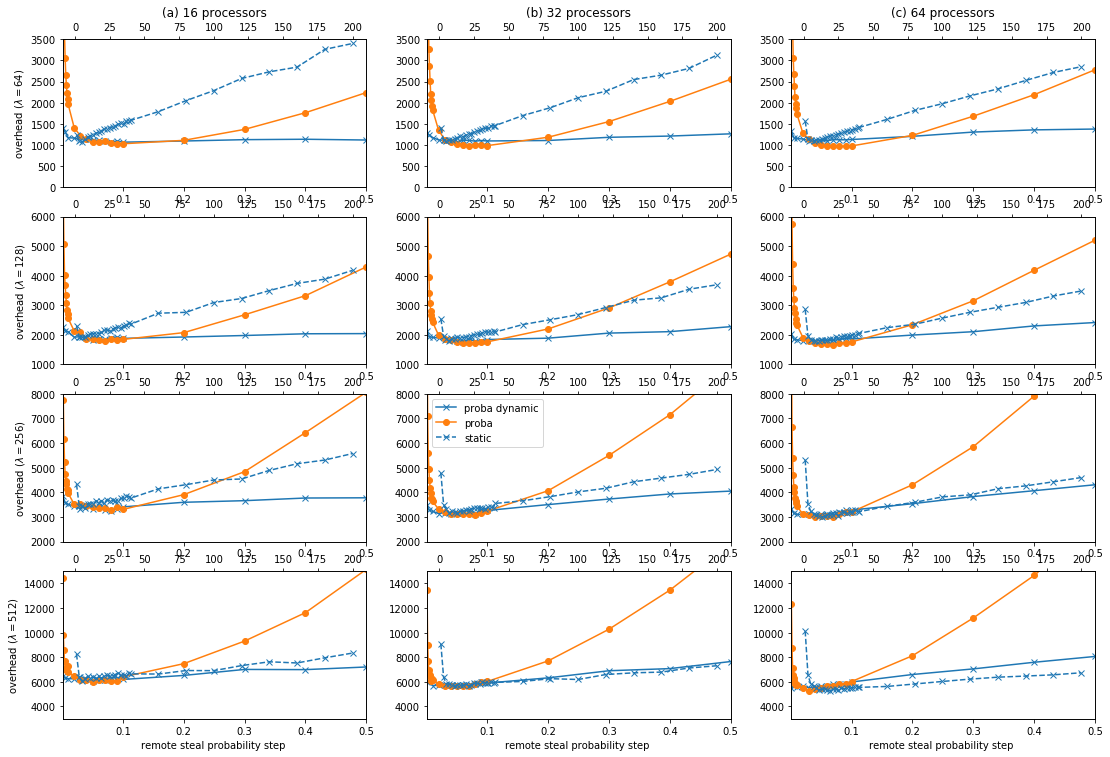

In [20]:
fig = plt.figure()
fig.set_size_inches(18.5, 12.5, forward=True)

#plt.xlim(0.001, 0.5)
position = 0
#for (l,lim) in sorted({(128,6000),(256,8000),(512,15000)}):
for (l, limy, limx) in sorted({(64,0,3500),(128, 1000, 6000),(256, 2000, 8000),(512,3000, 15000)}):
    
    for p,c in sorted({(16,"(a)"),(32,"(b)"),(64,"(c)")}):
        #position
        position += 1
        plt.subplot(4, 3, position)

        #labels
        if l == 512:
            plt.xlabel("remote steal probability step ")
        if l == 64:
            plt.title(c+" "+str(p)+" processors")
        if p == 16:
            plt.ylabel("overhead ($\lambda = "+str(l)+"$)")
        
        #limits
        plt.xlim(0.001, 0.5)
        plt.ylim(limy, limx)
        
        #plots
        axes1 = fig.add_subplot(4, 3, position)
        axes2 = axes1.twiny()    # share the y-axis


        data = load_file(directory_pd + "vss_proba_dynamic_" + str(p) + "_" + str(w), line=18)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns1 = axes1.plot(overhead.keys(), overhead.values(), "x-", label="proba dynamic")


        data = load_file(directory_p + "vss_proba_" + str(p) + "_" + str(w), line=0)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns2 = axes1.plot(overhead.keys(), overhead.values(), "o-", label="proba")

        data = load_file(directory_s + "vss_static_" + str(p) + "_" + str(w), line=0)
        all_average, overhead, minimum = compute_overhead_for_latence(data, l)
        lns3 = axes2.plot(overhead.keys(), overhead.values(), "x--", label="static")


        #axes1.legend()
        #axes2.legend()             
        #axes1.legend(('label1', 'label2', 'label3'))        #legend
        if p == 32 and l == 256: 
            lns = lns1+lns2+lns3
            labs = [l.get_label() for l in lns]
            axes1.legend(lns, labs, loc=0)


plt.savefig('../../../../../Manuscrit/manuscrit/gfx/twoClusters/comp_vss_50p.pdf',bbox_inches='tight')
